# Clusterização de Perfis Hematológicos - K-Means

**Objetivo:** Agrupar pacientes com perfis hematológicos similares para identificar padrões e subgrupos clínicos.

## O que vamos fazer:

1. Encontrar o número ótimo de clusters
2. Aplicar K-Means clustering
3. Visualizar clusters em 2D (PCA e UMAP)
4. Caracterizar cada cluster
5. Interpretação clínica dos grupos

## Por que isso é útil?

**Para Médicos:**
- Identificar subgrupos de pacientes com perfis similares
- Personalizar tratamentos baseado no cluster
- Detectar padrões não óbvios nos dados

**Para Pesquisa:**
- Descoberta de fenótipos hematológicos
- Estratificação de pacientes
- Hipóteses para estudos futuros

## 1. Importação de Bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import umap

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Configuração de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)

# Importar classes do projeto
import sys
sys.path.append('../src')
from models import ClusterizadorPerfis

print(" Bibliotecas importadas com sucesso!")

✓ Bibliotecas importadas com sucesso!


## 2. Carregar Dados Limpos

In [ ]:
# Carregar dataset limpo
df = pd.read_csv('../data/processed/cbc_limpo.csv')

print(f" Dataset carregado: {df.shape[0]:,} linhas × {df.shape[1]} colunas")
df.head()

✓ Dataset carregado: 424 linhas × 21 colunas


,ID,WBC,LYMp,MIDp,NEUTp,LYMn,MIDn,NEUTn,RBC,HGB,HCT,MCV,MCH,MCHC,RDWSD,RDWCV,PLT,MPV,PDW,PCT,PLCR
0,1,10000.0,43.2,6.7,50.1,4.3,0.7,5.0,2.77,7.3,24.2,87.7,26.3,30.1,35.3,11.4,189000.0,9.2,12.5,0.17,22.3
1,3,7200.0,30.7,8.6,60.7,2.2,0.6,4.4,3.97,9.0,30.5,77.0,22.6,29.5,37.2,13.7,148000.0,10.1,14.3,0.14,30.5
2,4,6000.0,30.2,6.3,63.5,1.8,0.4,3.8,4.22,5.9,32.8,77.9,23.2,29.8,46.5,17.0,143000.0,8.6,11.3,0.12,16.4
3,7,16700.0,19.1,12.7,68.2,3.2,2.1,11.4,5.15,14.2,44.8,87.1,27.5,31.6,39.0,12.7,151000.0,9.7,12.8,0.14,26.6
4,8,9300.0,27.4,8.6,64.0,2.6,0.8,5.9,4.39,12.0,37.9,86.4,27.3,31.6,37.2,12.2,194000.0,10.2,15.9,0.19,31.1


## 3. Preparação dos Dados

In [ ]:
# Selecionar features para clustering
features_clustering = ['WBC', 'RBC', 'HGB', 'HCT', 'MCV', 'MCH', 'MCHC', 'PLT']
features_disponiveis = [f for f in features_clustering if f in df.columns]

print(f"✓ Features para clustering: {features_disponiveis}")

X = df[features_disponiveis].copy()
print(f"\n Shape: {X.shape}")
print(f" Valores faltantes: {X.isnull().sum().sum()}")

✓ Features para clustering: ['WBC', 'RBC', 'HGB', 'HCT', 'MCV', 'MCH', 'MCHC', 'PLT']

📊 Shape: (424, 8)
📊 Valores faltantes: 0


## 4. Padronização

In [ ]:
# Padronizar dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(" Dados padronizados (média=0, std=1)")
print(f"\n Shape após padronização: {X_scaled.shape}")

✓ Dados padronizados (média=0, std=1)

📊 Shape após padronização: (424, 8)


## 5. Encontrar Número Ótimo de Clusters

Vamos usar três métodos:
1. **Método do Cotovelo** (Elbow Method)
2. **Silhouette Score** (maior é melhor)
3. **Davies-Bouldin Index** (menor é melhor)

🔍 Testando diferentes números de clusters...


📊 Recomendações:
  • Melhor Silhouette Score: 2 clusters
  • Melhor Davies-Bouldin: 8 clusters

✓ Gráfico salvo: reports/figures/03_otimizacao_clusters.png


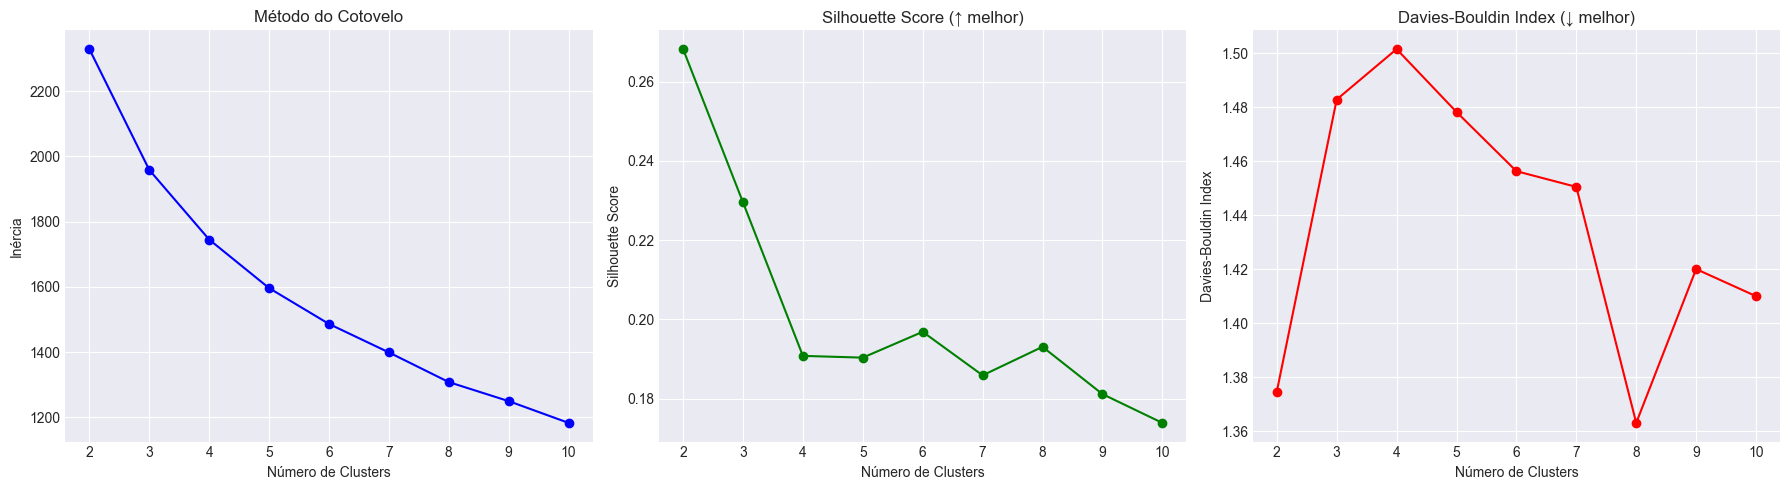

In [ ]:
# Criar clusterizador
clusterizador = ClusterizadorPerfis(n_clusters=3, metodo='kmeans')

# Encontrar número ótimo de clusters
print(" Testando diferentes números de clusters...\n")
resultados = clusterizador.encontrar_n_clusters_otimo(X_scaled, max_clusters=10)

plt.savefig('../reports/figures/03_otimizacao_clusters.png', dpi=300, bbox_inches='tight')
print("\n Gráfico salvo: reports/figures/03_otimizacao_clusters.png")
plt.show()

## 6. Determinação do numero de clusters

O número de clusters foi definido como 3 com base na análise conjunta do método do cotovelo, do Silhouette Score e do índice de Davies–Bouldin. Embora k=2 tenha apresentado maior Silhouette Score, essa configuração resulta em segmentação excessivamente simplificada. O valor k=3 representa o melhor equilíbrio entre separação estatística, redução da inércia e interpretabilidade clínica, permitindo a identificação de perfis hematológicos distintos e clinicamente relevantes.

## 6.1 Aplicar K-Means com Número Ótimo

In [6]:
n_clusters_otimo = 3 

print(f"📊 Número de clusters escolhido: {n_clusters_otimo}")
print("\n🔄 Treinando modelo K-Means...")

# Criar e treinar clusterizador
clusterizador = ClusterizadorPerfis(n_clusters=n_clusters_otimo, metodo='kmeans')
labels = clusterizador.treinar(X_scaled)

# Adicionar labels ao dataframe original
df['cluster'] = labels

📊 Número de clusters escolhido: 3

🔄 Treinando modelo K-Means...

✓ Clusterização concluída!
  • Método: kmeans
  • Número de clusters: 3
  • Silhouette Score: 0.230
  • Davies-Bouldin Index: 1.483

📊 Distribuição dos clusters:
  • Cluster 0: 165 amostras (38.9%)
  • Cluster 1: 109 amostras (25.7%)
  • Cluster 2: 150 amostras (35.4%)


## 7. Visualização dos Clusters - PCA

✓ Gráfico salvo: reports/figures/03_clusters_pca.png


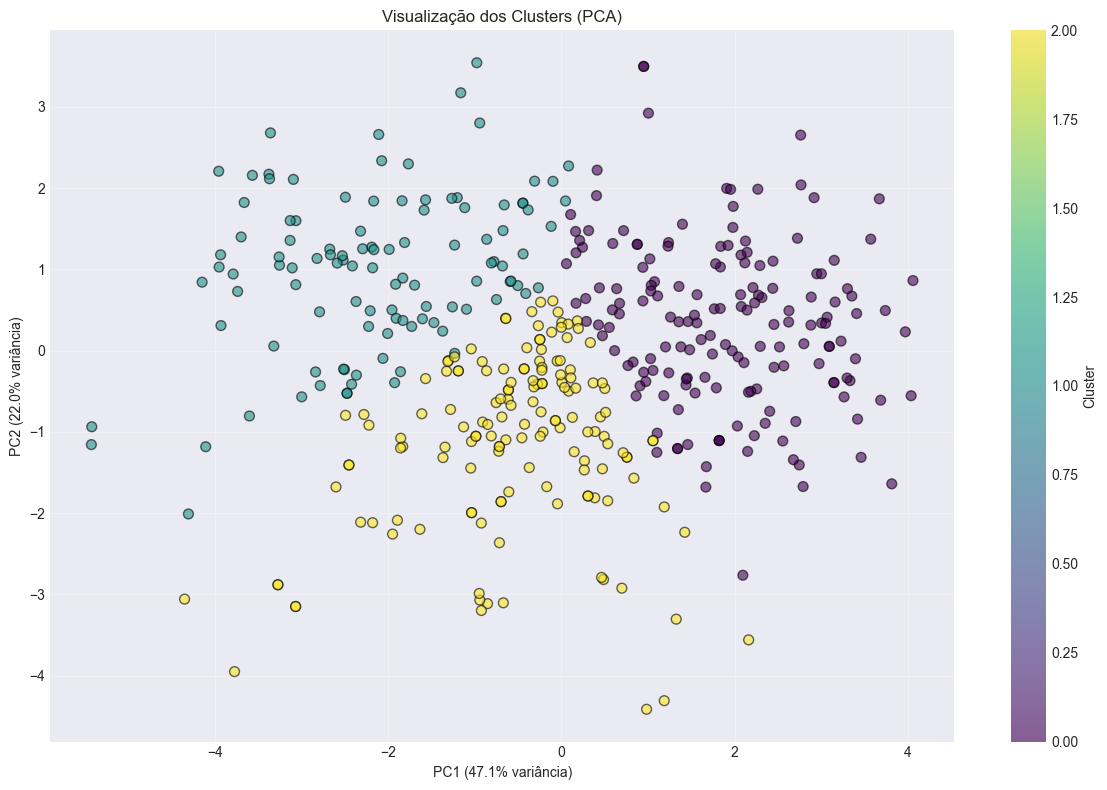


📊 Variância explicada pelo PCA:
  • PC1: 47.14%
  • PC2: 22.00%
  • Total: 69.15%


In [7]:
# Visualizar com PCA
fig_pca, pca_obj = clusterizador.visualizar_clusters_pca(X_scaled, labels)

plt.savefig('../reports/figures/03_clusters_pca.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico salvo: reports/figures/03_clusters_pca.png")
plt.show()

print(f"\n📊 Variância explicada pelo PCA:")
print(f"  • PC1: {pca_obj.explained_variance_ratio_[0]*100:.2f}%")
print(f"  • PC2: {pca_obj.explained_variance_ratio_[1]*100:.2f}%")
print(f"  • Total: {sum(pca_obj.explained_variance_ratio_[:2])*100:.2f}%")

## 8. Visualização dos Clusters - UMAP

**UMAP** geralmente preserva melhor a estrutura local dos dados que PCA.

🔄 Aplicando UMAP (pode levar alguns segundos...)

✓ Gráfico salvo: reports/figures/03_clusters_umap.png


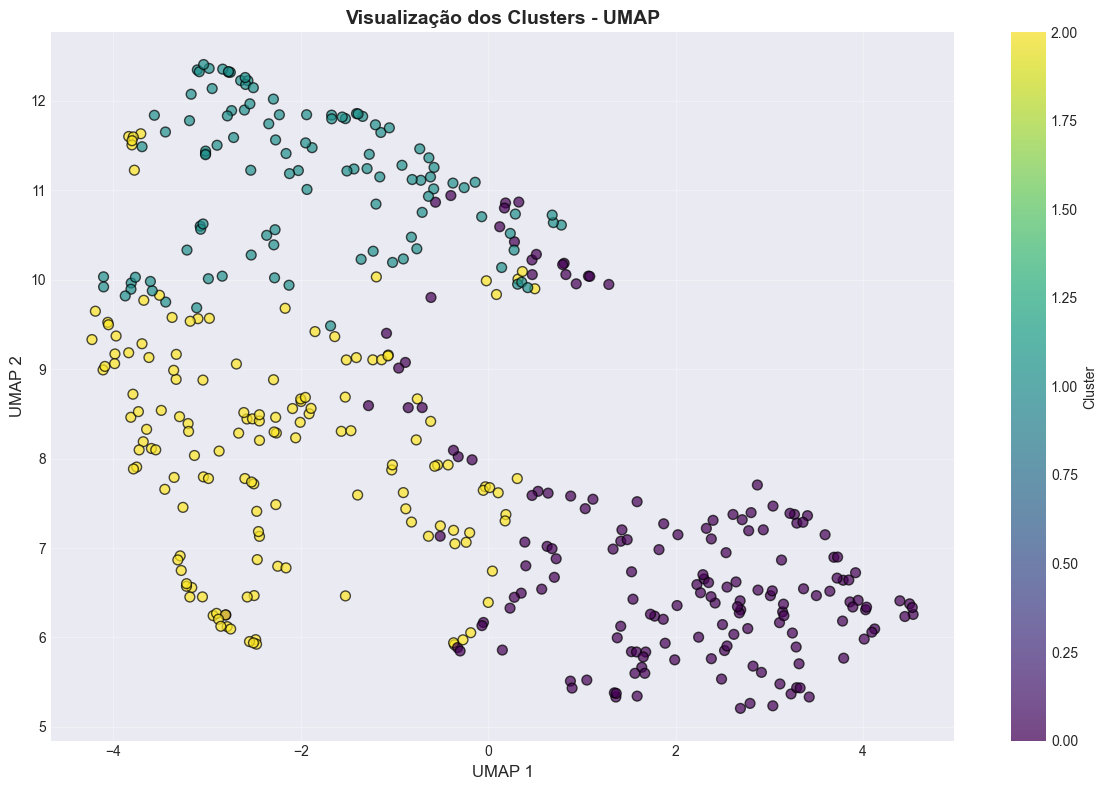

In [ ]:
# Aplicar UMAP
print(" Aplicando UMAP \n")

reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
X_umap = reducer.fit_transform(X_scaled)

# Visualizar
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(X_umap[:, 0], X_umap[:, 1], 
                    c=labels, cmap='viridis', 
                    s=50, alpha=0.7, edgecolors='black')

ax.set_xlabel('UMAP 1', fontsize=12)
ax.set_ylabel('UMAP 2', fontsize=12)
ax.set_title('Visualização dos Clusters - UMAP', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cluster', ax=ax)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/03_clusters_umap.png', dpi=300, bbox_inches='tight')
print(" Gráfico salvo: reports/figures/03_clusters_umap.png")
plt.show()

## 9. Caracterização dos Clusters

Vamos entender **o que define cada cluster**!

In [9]:
# Caracterizar clusters
caracteristicas = clusterizador.caracterizar_clusters(X, labels, features_disponiveis)


📊 Características médias por cluster:
             WBC   RBC    HGB    HCT    MCV    MCH   MCHC        PLT
Cluster                                                             
0        7272.73  5.00  13.78  42.90  85.59  27.39  32.00  155757.58
1        7861.47  4.54  10.22  34.36  75.38  22.45  29.87  187046.79
2        6598.00  4.07  10.72  34.74  85.24  26.31  30.88  164126.67


✓ Gráfico salvo: reports/figures/03_caracteristicas_clusters.png


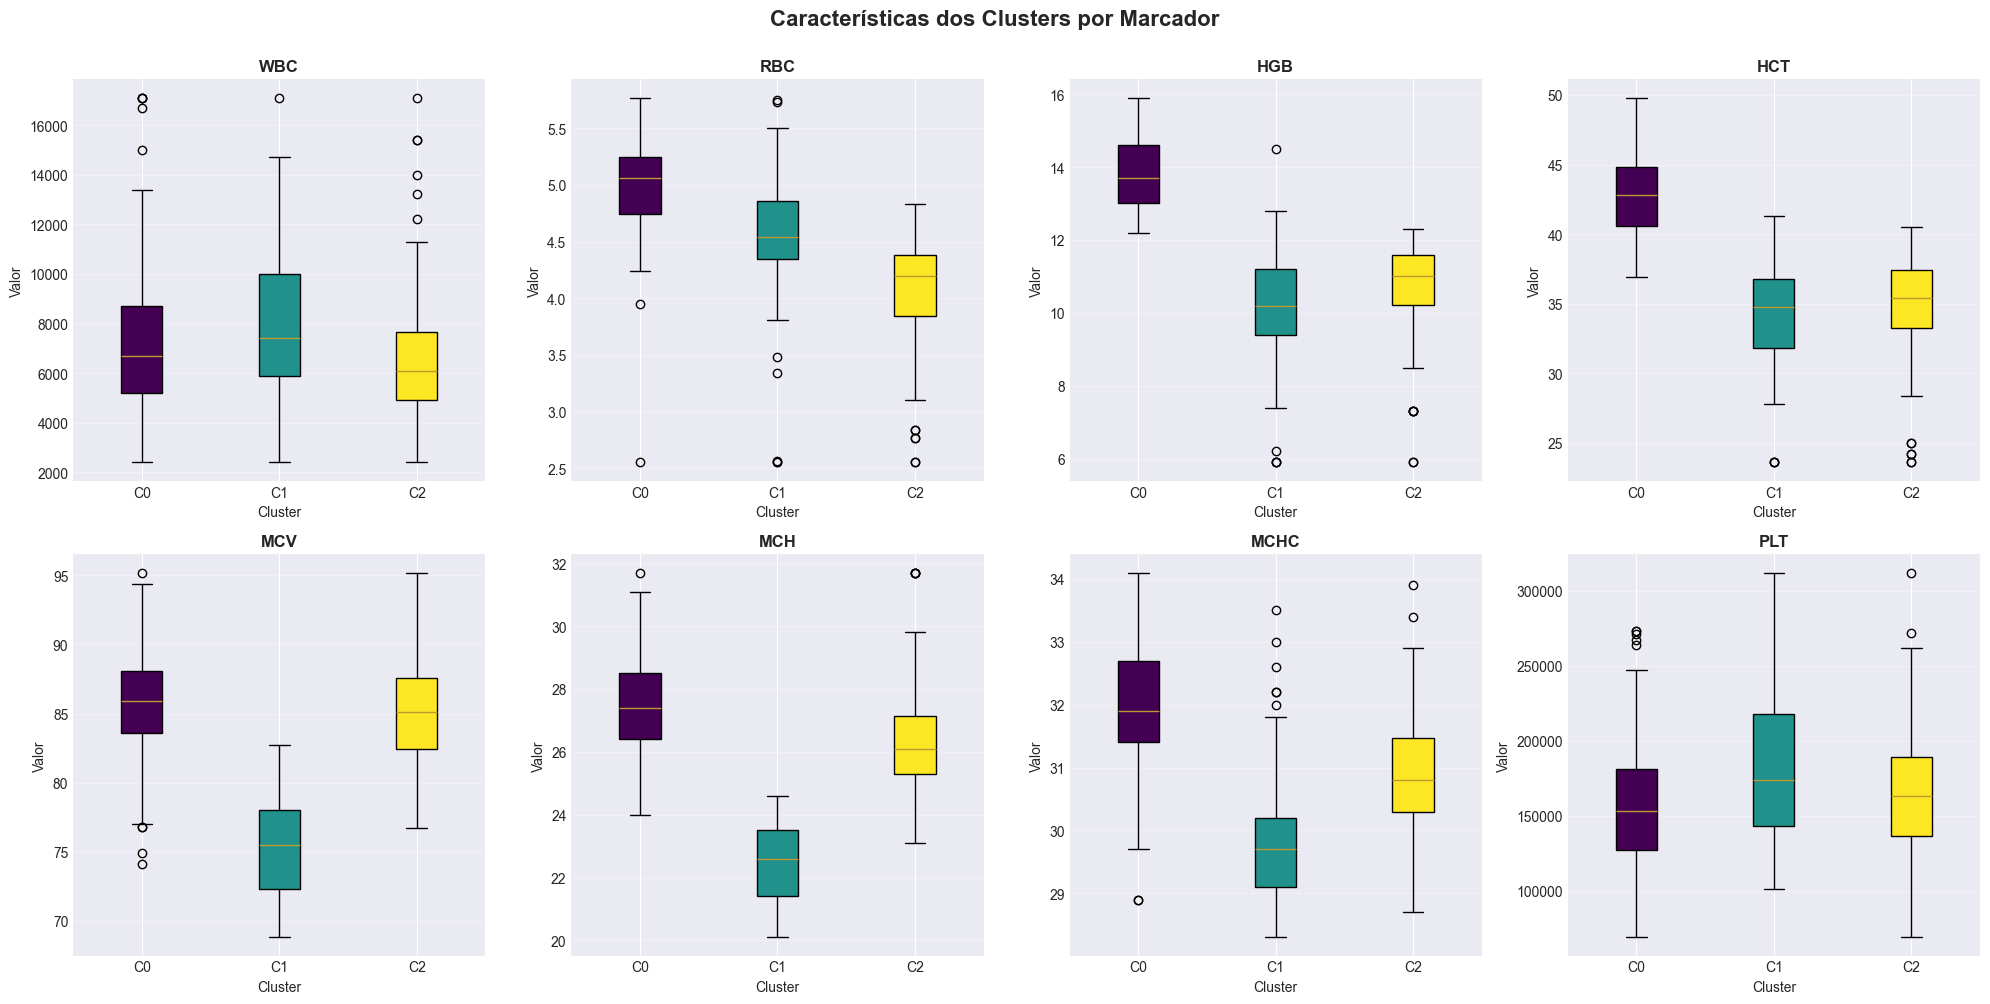

In [10]:
# Visualizar características por cluster
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, feature in enumerate(features_disponiveis):
    ax = axes[idx]
    
    # Criar dados para cada cluster
    data_por_cluster = [df[df['cluster'] == i][feature].dropna() 
                       for i in range(n_clusters_otimo)]
    
    # Boxplot
    bp = ax.boxplot(data_por_cluster, 
                    labels=[f'C{i}' for i in range(n_clusters_otimo)],
                    patch_artist=True)
    
    # Colorir
    colors = plt.cm.viridis(np.linspace(0, 1, n_clusters_otimo))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_title(f'{feature}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Valor', fontsize=10)
    ax.set_xlabel('Cluster', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Características dos Clusters por Marcador', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('../reports/figures/03_caracteristicas_clusters.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico salvo: reports/figures/03_caracteristicas_clusters.png")
plt.show()

## 10. Perfil Detalhado de Cada Cluster

In [ ]:
# Valores de referência
valores_ref = {
    'HGB': {'min': 12.0, 'max': 16.0, 'nome': 'Hemoglobina'},
    'HCT': {'min': 36.0, 'max': 48.0, 'nome': 'Hematócrito'},
    'WBC': {'min': 4000, 'max': 11000, 'nome': 'Leucócitos'},
    'PLT': {'min': 150000, 'max': 400000, 'nome': 'Plaquetas'},
    'MCV': {'min': 80.0, 'max': 100.0, 'nome': 'VCM'},
}

print("="*70)
print(" PERFIL CLÍNICO DE CADA CLUSTER")
print("="*70)

for cluster_id in range(n_clusters_otimo):
    cluster_data = df[df['cluster'] == cluster_id]
    n_pacientes = len(cluster_data)
    
    print(f"\n{'='*70}")
    print(f" CLUSTER {cluster_id}")
    print(f"{'='*70}")
    print(f" Tamanho: {n_pacientes} pacientes ({n_pacientes/len(df)*100:.1f}%)\n")
    
    for marcador, ref in valores_ref.items():
        if marcador in cluster_data.columns:
            media = cluster_data[marcador].mean()
            mediana = cluster_data[marcador].median()
            
            # Classificação
            if media < ref['min']:
                status = "⬇️ BAIXO"
            elif media > ref['max']:
                status = "⬆️ ALTO"
            else:
                status = "✅ NORMAL"
            
            # % fora da referência
            abaixo = (cluster_data[marcador] < ref['min']).sum()
            acima = (cluster_data[marcador] > ref['max']).sum()
            
            print(f"{ref['nome']} ({marcador}): {status}")
            print(f"  • Média: {media:.2f} (Ref: {ref['min']}-{ref['max']})")
            print(f"  • Abaixo: {abaixo/n_pacientes*100:.1f}% | Acima: {acima/n_pacientes*100:.1f}%")
    
    print()

📊 PERFIL CLÍNICO DE CADA CLUSTER

🧬 CLUSTER 0
📊 Tamanho: 165 pacientes (38.9%)

Hemoglobina (HGB): ✅ NORMAL
  • Média: 13.78 (Ref: 12.0-16.0)
  • Abaixo: 0.0% | Acima: 0.0%
Hematócrito (HCT): ✅ NORMAL
  • Média: 42.90 (Ref: 36.0-48.0)
  • Abaixo: 0.0% | Acima: 6.7%
Leucócitos (WBC): ✅ NORMAL
  • Média: 7272.73 (Ref: 4000-11000)
  • Abaixo: 9.7% | Acima: 8.5%
Plaquetas (PLT): ✅ NORMAL
  • Média: 155757.58 (Ref: 150000-400000)
  • Abaixo: 44.8% | Acima: 0.0%
VCM (MCV): ✅ NORMAL
  • Média: 85.59 (Ref: 80.0-100.0)
  • Abaixo: 7.9% | Acima: 0.0%


🧬 CLUSTER 1
📊 Tamanho: 109 pacientes (25.7%)

Hemoglobina (HGB): ⬇️ BAIXO
  • Média: 10.22 (Ref: 12.0-16.0)
  • Abaixo: 91.7% | Acima: 0.0%
Hematócrito (HCT): ⬇️ BAIXO
  • Média: 34.36 (Ref: 36.0-48.0)
  • Abaixo: 62.4% | Acima: 0.0%
Leucócitos (WBC): ✅ NORMAL
  • Média: 7861.47 (Ref: 4000-11000)
  • Abaixo: 8.3% | Acima: 17.4%
Plaquetas (PLT): ✅ NORMAL
  • Média: 187046.79 (Ref: 150000-400000)
  • Abaixo: 31.2% | Acima: 0.0%
VCM (MCV): ⬇️ BAIXO
 

## 11. Interpretação Clínica dos Clusters

In [ ]:
# Mapeamento de interpretações clínicas baseado nos perfis reais dos clusters

interpretacoes_clusters = {
    0: {
        'nome': 'Perfil Hematológico Preservado',
        'descricao': (
            'Pacientes com hemoglobina, hematócrito e VCM dentro da normalidade, '
            'sem sinais claros de anemia, podendo apresentar plaquetopenia leve.'
        ),
        'caracteristicas': [
            'Hemoglobina e hematócrito normais',
            'VCM dentro da faixa de normalidade',
            'Leucócitos geralmente normais',
            'Plaquetas reduzidas em parte dos casos'
        ]
    },
    1: {
        'nome': 'Perfil Anêmico',
        'descricao': (
            'Pacientes com redução significativa da hemoglobina e do hematócrito, '
            'compatível com quadros anêmicos.'
        ),
        'caracteristicas': [
            'Hemoglobina abaixo do valor de referência',
            'Hematócrito reduzido',
            'VCM normal ou reduzido',
            'Possível anemia ferropriva ou anemia crônica'
        ]
    },
    2: {
        'nome': 'Perfil Inflamatório / Misto',
        'descricao': (
            'Pacientes com alterações combinadas nos marcadores hematológicos, '
            'incluindo leucocitose ou leucopenia, podendo indicar processos inflamatórios '
            'ou infecciosos associados.'
        ),
        'caracteristicas': [
            'Leucócitos alterados',
            'Possíveis alterações em plaquetas',
            'Padrão hematológico heterogêneo',
            'Necessidade de investigação clínica complementar'
        ]
    }
}

# Adicionar interpretações ao dataframe
df['cluster_nome'] = df['cluster'].map(
    lambda x: interpretacoes_clusters.get(x, {}).get('nome', f'Cluster {x}')
)

print("✓ Interpretações clínicas adicionadas com sucesso!")
print("\n Distribuição dos perfis clínicos:")
print(df['cluster_nome'].value_counts())

✓ Interpretações clínicas adicionadas com sucesso!

📊 Distribuição dos perfis clínicos:
cluster_nome
Perfil Hematológico Preservado    165
Perfil Inflamatório / Misto       150
Perfil Anêmico                    109
Name: count, dtype: int64


## * Parágrafo de Discussão – Interpretação dos Clusters

Apesar de um dos grupos ter sido classificado como “Perfil Hematológico Preservado”, a análise detalhada revela que esse cluster não representa indivíduos estritamente normais do ponto de vista clínico. Observa-se que uma parcela significativa dos pacientes apresenta plaquetopenia leve e variações nos níveis de leucócitos, ainda que hemoglobina, hematócrito e VCM permaneçam dentro dos valores de referência. Esse achado evidencia que a clusterização não substitui a avaliação clínica individual, mas funciona como uma ferramenta de segmentação de perfis laboratoriais, assim o achei valido por estar permitindo identificar padrões predominantes e grupos de risco.

## 12. Visualização Final - Radar Plot dos Clusters

✓ Gráfico salvo: reports/figures/03_radar_clusters.png


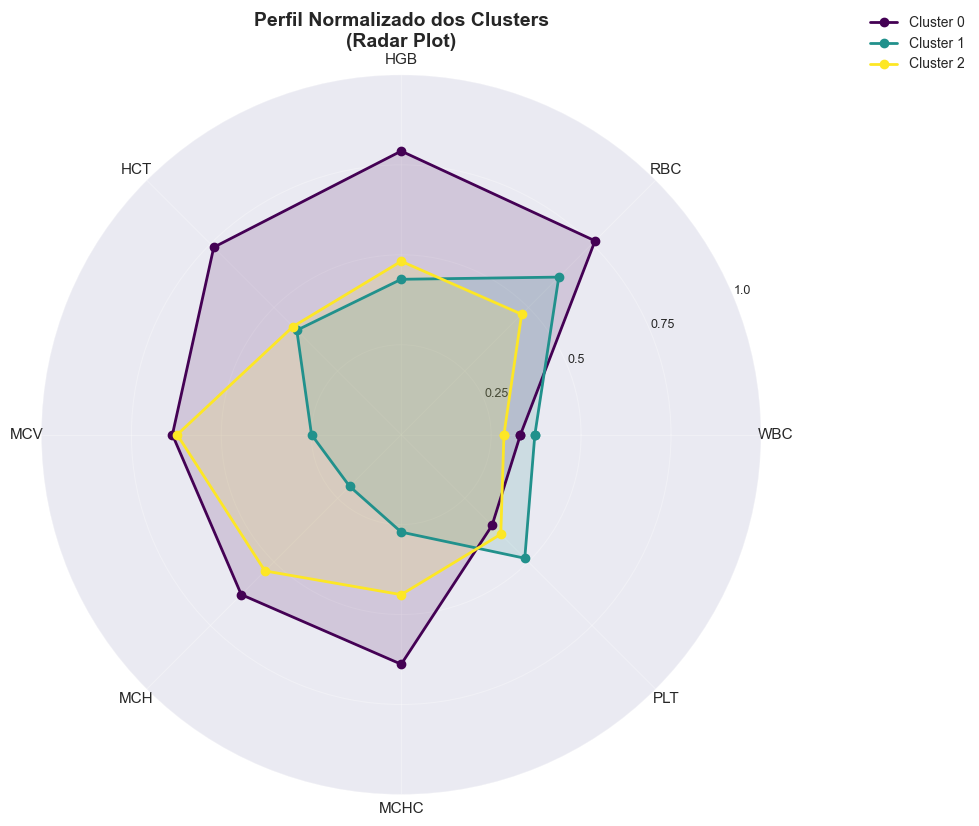

In [ ]:
# Criar radar plot (gráfico de aranha)
from math import pi

# Normalizar dados para 0-1 para melhor visualização
X_norm = (X - X.min()) / (X.max() - X.min())

# Calcular médias normalizadas por cluster
medias_norm = pd.DataFrame()
for cluster_id in range(n_clusters_otimo):
    mask = df['cluster'] == cluster_id
    medias_norm[f'Cluster {cluster_id}'] = X_norm[mask].mean()

# Configurar radar plot
categories = features_disponiveis
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Criar figura
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Plotar cada cluster
colors = plt.cm.viridis(np.linspace(0, 1, n_clusters_otimo))

for idx, cluster_id in enumerate(range(n_clusters_otimo)):
    values = medias_norm[f'Cluster {cluster_id}'].tolist()
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, 
           label=f'Cluster {cluster_id}', color=colors[idx])
    ax.fill(angles, values, alpha=0.15, color=colors[idx])

# Configurar eixos
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=11)
ax.set_ylim(0, 1)
ax.set_yticks([0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(['0.25', '0.5', '0.75', '1.0'], size=9)
ax.grid(True, alpha=0.3)

plt.title('Perfil Normalizado dos Clusters\n(Radar Plot)', 
         size=14, fontweight='bold', pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.savefig('../reports/figures/03_radar_clusters.png', dpi=300, bbox_inches='tight')
print(" Gráfico salvo: reports/figures/03_radar_clusters.png")
plt.show()

## 13. Salvar Resultados

In [ ]:
# Salvar dataset com clusters
df.to_csv('../data/processed/cbc_com_clusters.csv', index=False)

print("✓ Dataset com clusters salvo!")
print("   Arquivo: data/processed/cbc_com_clusters.csv")
print(f"\n Colunas adicionadas:")
print("  • cluster (ID numérico do cluster)")
print("  • cluster_nome (Interpretação clínica do cluster)")

# Salvar resumo dos clusters
resumo_clusters = caracteristicas.copy()
resumo_clusters.to_csv('../reports/resumo_clusters.csv')
print("\n✓ Resumo dos clusters salvo em: reports/resumo_clusters.csv")

✓ Dataset com clusters salvo!
  📂 Arquivo: data/processed/cbc_com_clusters.csv

📊 Colunas adicionadas:
  • cluster (ID numérico do cluster)
  • cluster_nome (Interpretação clínica do cluster)

✓ Resumo dos clusters salvo em: reports/resumo_clusters.csv


## 📝 14. Principais Insights e Conclusões

### ✅ Resumo Executivo:

1. **Quantos clusters foram encontrados?**
   - Foram identificados 3 clusters, definidos a partir da análise conjunta do método do cotovelo, Silhouette Score e índice de Davies–Bouldin.

2. **Como você nomearia cada cluster?**

Cluster 0 – Perfil Hematológico Preservado (165 pacientes)
Pacientes com hemoglobina, hematócrito e VCM dentro dos valores de referência, sem sinais claros de anemia, embora uma parcela apresente plaquetopenia leve e pequenas variações nos leucócitos.

Cluster 1 – Perfil Inflamatório / Misto (150 pacientes)
Pacientes com alterações combinadas nos marcadores hematológicos, principalmente nos leucócitos, podendo apresentar leucocitose ou leucopenia associada a variações em plaquetas e eritrócitos, sugerindo processos inflamatórios, infecciosos ou condições clínicas complexas.

Cluster 2 – Perfil Anêmico (109 pacientes)
Pacientes com redução significativa da hemoglobina e do hematócrito, frequentemente acompanhada de alterações no VCM, compatíveis com quadros anêmicos, como anemia ferropriva ou anemia associada a doenças crônicas.

3. **Qual cluster é mais prevalente?**
   - O Perfil Hematológico Preservado (Cluster 0) é o mais prevalente, representando 165 pacientes (38,9%) da amostra.

4. **Principais diferenças entre clusters:**

Hemoglobina (HGB) e Hematócrito (HCT) → principais discriminadores do perfil anêmico

Leucócitos (WBC) → diferenciam o perfil inflamatório/misto

Plaquetas (PLT) → variam entre os perfis, especialmente com plaquetopenia em parte dos pacientes

VCM (MCV) → auxilia na caracterização do tipo de ane

5. **Interpretação clínica:**

Os clusters representam perfis hematológicos distintos, permitindo a segmentação dos pacientes em grupos com características laboratoriais semelhantes. Essa abordagem não substitui o diagnóstico clínico, mas auxilia na identificação de padrões relevantes, estratificação de risco e priorização de casos que necessitam de investigação adicional.

6. **Aplicações práticas:**
   - Como isso ajudaria na triagem de pacientes?

Identificação automática de perfis anormais

Priorização de exames sugestivos de anemia ou inflamação

Redução do tempo de análise manual em grandes volumes de hemogramas

   - Como isso ajudaria na personalização de tratamentos?

Apoio à decisão clínica para investigação precoce de anemia

Monitoramento diferenciado de pacientes com perfil inflamatório

Possibilidade de acompanhamento longitudinal conforme o perfil hematológico